<a href="https://colab.research.google.com/github/aleCastanheira/TCC_MBA/blob/main/TCC_deep_leraning_LSTM_study_for_datalake_anomalies_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

No setup deste notebook, importo as bibliotecas, defino as constantes e a configuração do pandas.

In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
from random import sample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
import pickle


np.random.seed(1)
tf.random.set_seed(1)

from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [4]:
# CONSTANTES DO SCRIPT
FILEPATH = "/content/drive/MyDrive/TCC"
PROCESSED_METADATA_FILE = "processed_metadata.csv"
PROCESSED_METADATA_OUTLIERS_FILE = "processed_metadata_outliers.csv"
PROCESSED_METADATA_FILEPATH = f"{FILEPATH}/{PROCESSED_METADATA_FILE}"
PROCESSED_METADATA_OUTLIERS_FILEPATH = f"{FILEPATH}/{PROCESSED_METADATA_OUTLIERS_FILE}"

MODEL_NAME = FILEPATH + "/TCC_LSTM_trained_model"

REF_DATE_KEY = "reference_date"
TOTAL_SIZE = "total_size"
TABLE_KEY = "table"

TIMESERIES_COLUMNS = [REF_DATE_KEY, TOTAL_SIZE]

# tabelas usadas para teste
tab_list = [
    'TAB000001', # crescimento constante, sem outliers aparente
    'TAB000005', # mantém um padrão constante, não deve ter outliers
    'TAB000008', # um pico grande no ano um
]

# outliers inseridos manualmente
added_noise_multiplier = {
    "TAB000005": [("2022-01-02", 0), ("2022-04-01", 0), ("2022-08-01", 0)],
    "TAB000008": [("2022-12-10", 0)],
}

# Range de datas usadas para os rótulos dos gráficos no eixo X
def get_date_strings(start_interval, end_interval):
    timestamps = pd.date_range(start=start_interval, end=end_interval, periods=6, inclusive='both')
    date_strings = [ts.strftime('%Y-%m-%d') for ts in timestamps]
    return date_strings

interval_list = [
    (
        "2021-01-01",
        "2021-06-30",
        get_date_strings("2021-01-01", "2021-06-30")
    ), #6 meses
    (
        "2021-01-01",
        "2021-12-31",
        get_date_strings("2021-01-01", "2021-12-31")
    ), #1 ano
    (
        "2021-01-01",
        "2022-12-31",
        get_date_strings("2021-01-01", "2022-12-31")
    ), #2 anos
]

metadata_files = [
    PROCESSED_METADATA_FILEPATH,
    PROCESSED_METADATA_OUTLIERS_FILEPATH
]

train_mode = False

test_list = [
    #0:
    {"table_for_test": tab_list[0], "interval_for_test": interval_list[0], "filepath_for_test": metadata_files[1]},
    #1:
    {"table_for_test": tab_list[0], "interval_for_test": interval_list[2], "filepath_for_test": metadata_files[1]},
    #2:
    {"table_for_test": tab_list[1], "interval_for_test": interval_list[1], "filepath_for_test": metadata_files[1]},
    #3:
    {"table_for_test": tab_list[1], "interval_for_test": interval_list[2], "filepath_for_test": metadata_files[1]},
    #4:
    {"table_for_test": tab_list[2], "interval_for_test": interval_list[1], "filepath_for_test": metadata_files[1]},
    #5:
    {"table_for_test": tab_list[2], "interval_for_test": interval_list[2], "filepath_for_test": metadata_files[1]},
]

training_list = [
    #0:
    {"table_for_test": tab_list[0], "interval_for_test": interval_list[2], "filepath_for_test": metadata_files[1]},
    #1:
    {"table_for_test": tab_list[1], "interval_for_test": interval_list[2], "filepath_for_test": metadata_files[1]},
    #2:
    {"table_for_test": tab_list[2], "interval_for_test": interval_list[2], "filepath_for_test": metadata_files[1]},
]

if train_mode:
    test_list = training_list


#hyperparams

In [5]:
test_choosen = 2

train_percentage = 0.8

batch_size = 32
dropout_rate = 0.2
network_units = 128
optimizer = 'adam'
loss = 'mse'

TABLE_FOR_TEST_01 = test_list[test_choosen]["table_for_test"]
START_DATE_INTERVAL = test_list[test_choosen]["interval_for_test"][0]
END_DATE_INTERVAL = test_list[test_choosen]["interval_for_test"][1]
METADATA_FILEPATH = test_list[test_choosen]["filepath_for_test"]

TIME_STEPS = 15

threshold_list = {
    0: -0.1,
    1: -0.1,
    2: -0.3,
    3: -0.3,
    4: -0.7,
    5: 0.6,
}

In [6]:
def get_saved_model():
    # carregar o modelo XGBoost do arquivo sale_xgboost.pkl
    with open(MODEL_NAME + TABLE_FOR_TEST_01 + ".pkl", 'rb') as file:
        model = pickle.load(file)

    return model

def save_model(model):
    # salvar o modelo XGBoost (xgb_model) no arquivo sale_xgboost.pkl
    with open(MODEL_NAME + TABLE_FOR_TEST_01 + ".pkl", 'wb') as file:
        pickle.dump(model, file)

In [7]:
# Configuração para mostrar todos os atributos
pd.set_option('display.max_columns', None)

df = pd.read_csv(METADATA_FILEPATH, parse_dates=False)
# df.sort_values(by=ORDER_BY_COLUMNS)

# Preparando o dataset para análise de série temporal.

## Realizando a filtragem do dataset

In [8]:
# Filtrando para trazer apenas uma tabela
df = df[df[TABLE_KEY] == TABLE_FOR_TEST_01].copy()
df = df[(df[REF_DATE_KEY] >= START_DATE_INTERVAL) & (df[REF_DATE_KEY] <= END_DATE_INTERVAL)]
df[REF_DATE_KEY].min(), df[REF_DATE_KEY].max()

('2021-01-01', '2021-12-31')

In [9]:
# df = df[DATASET_COLUMN_LIST].copy()

# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.dropna(subset=DATASET_COLUMN_LIST, how='all', inplace=True)

# before_delete_dup = len(df.index)
# df.drop_duplicates(subset=[REFERENCE_TABLE_KEY, REF_DATE_KEY])
# after_delete_dup = len(df.index)

# before_delete_dup - after_delete_dup

## Ajustando a tipagem dos dados

In [10]:
df[TOTAL_SIZE].astype('Int64')
df[REF_DATE_KEY] = pd.to_datetime(df[REF_DATE_KEY])

In [11]:
# Deixando apenas as colunas necessárias para a análise de séries temporais
df = df[TIMESERIES_COLUMNS].copy()
df = df.sort_values(by=REF_DATE_KEY)
# df = df.set_index(REF_DATE_KEY)
df

,reference_date,total_size
5925,2021-01-01,188288
5926,2021-01-02,348035
5927,2021-01-03,386823
5928,2021-01-04,732807
5929,2021-01-05,802740
...,...,...
6285,2021-12-27,621703
6286,2021-12-28,737174
6287,2021-12-29,732050
6288,2021-12-30,725876


In [12]:
def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])

    return np.array(Xs), np.array(ys)

def get_model(X_train):
    if train_mode:
        return train_model(X_train)
    else:
        return get_saved_model()

def train_model(X_train):
    model = Sequential()
    model.add(LSTM(network_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=dropout_rate))
    model.add(RepeatVector(X_train.shape[1]))
    model.add(LSTM(network_units, return_sequences=True))
    model.add(Dropout(rate=dropout_rate))
    model.add(TimeDistributed(Dense(X_train.shape[2])))
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [13]:

train_size = int(len(df) * train_percentage)
test_size = len(df) - train_size
train, test = df[:train_size], df[train_size:]

train_size, test_size

(292, 73)

In [14]:
scaler = StandardScaler()
scaler = scaler.fit(train[[TOTAL_SIZE]])

train[TOTAL_SIZE] = scaler.transform(train[[TOTAL_SIZE]])
test[TOTAL_SIZE] = scaler.transform(test[[TOTAL_SIZE]])

<ipython-input-14-704e7f9ad066>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[TOTAL_SIZE] = scaler.transform(train[[TOTAL_SIZE]])
<ipython-input-14-704e7f9ad066>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[TOTAL_SIZE] = scaler.transform(test[[TOTAL_SIZE]])


In [15]:
X_train, y_train = create_sequences(train[[TOTAL_SIZE]], train[TOTAL_SIZE])
X_test, y_test = create_sequences(test[[TOTAL_SIZE]], test[TOTAL_SIZE])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (277, 15, 1)
Testing shape: (58, 15, 1)


In [16]:
model = get_model(X_train)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 15, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 15, 1)               │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 594,821 (2.27 MB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 396,548 (1.51 MB)

In [17]:

history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.1,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - loss: 0.4113 - val_loss: 0.6237
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.3638 - val_loss: 0.6181
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.3567 - val_loss: 0.6343
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.3785 - val_loss: 0.6196
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.3580 - val_loss: 0.6248


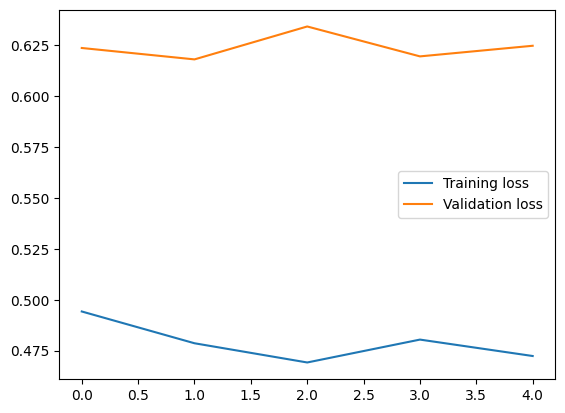

In [18]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [19]:
model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8248


0.9193458557128906

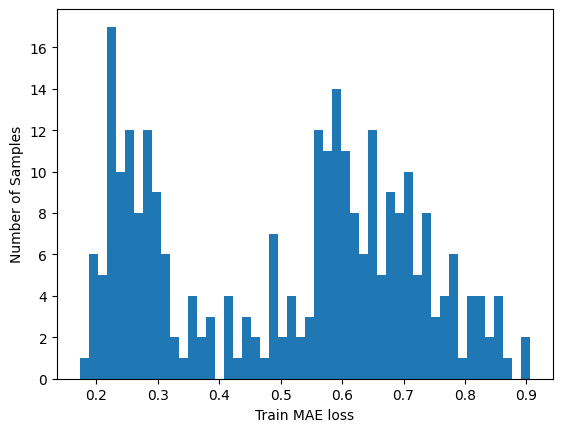

In [20]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

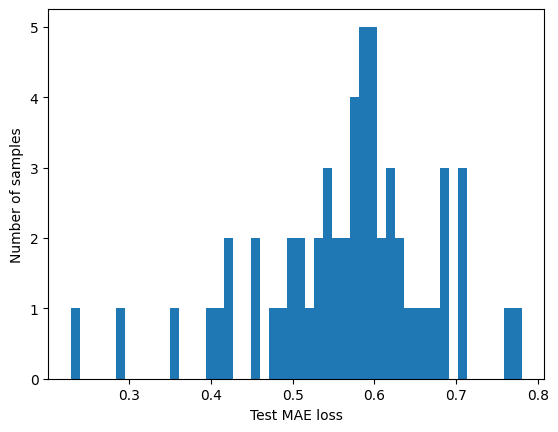

In [21]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

# threshold

In [22]:
threshold = np.max(train_mae_loss)

if threshold_list[test_choosen] > 0:
    threshold_adjust = threshold_list[test_choosen]
    threshold = threshold + (threshold * - threshold_adjust)
else:
    threshold_adjust = threshold_list[test_choosen]
    threshold = threshold - (threshold * - threshold_adjust)

# if threshold_list[test_choosen] != 1:
#     threshold_adjust = threshold_list[test_choosen]
#     threshold = threshold - (threshold * threshold_adjust)

print(f'Reconstruction error threshold: {threshold}')

Reconstruction error threshold: 0.6346300400995516


In [23]:
100*-0.1

-10.0

In [24]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df[TOTAL_SIZE] = test[TIME_STEPS:][TOTAL_SIZE]
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
results = len(anomalies.index)

print(f"Results para {TABLE_FOR_TEST_01}: {results}")

results

Results para TAB000005: 12


12

In [25]:
anomalies

,reference_date,total_size,loss,threshold,anomaly
6246,2021-11-18,2.029060,0.663339,0.63463,True
6247,2021-11-19,1.605754,0.691787,0.63463,True
6248,2021-11-20,0.905204,0.681526,0.63463,True
6249,2021-11-21,0.770829,0.655338,0.63463,True
6264,2021-12-06,0.804271,0.711906,0.63463,True
6265,2021-12-07,1.202466,0.710477,0.63463,True
6266,2021-12-08,0.630487,0.684850,0.63463,True
6267,2021-12-09,0.388741,0.638202,0.63463,True
6270,2021-12-12,-0.814894,0.674448,0.63463,True
6271,2021-12-13,0.049418,0.759486,0.63463,True


In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[REF_DATE_KEY], y=df[TOTAL_SIZE], name='Tamanho total de arquivos'))
fig.update_layout(showlegend=True, title='Tamanho total de arquivos entre 2020 e 2022')
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [27]:
pd.DataFrame(test[TIME_STEPS:])

,reference_date,total_size
6232,2021-11-04,1.151303
6233,2021-11-05,0.664546
6234,2021-11-06,-0.335494
6235,2021-11-07,-0.231912
6236,2021-11-08,1.246222
6237,2021-11-09,1.434871
6238,2021-11-10,1.415664
6239,2021-11-11,1.255071
6240,2021-11-12,0.716688
6241,2021-11-13,-0.157678


In [28]:
# test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:][TOTAL_SIZE]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df[REF_DATE_KEY], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df[REF_DATE_KEY], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df[REF_DATE_KEY], y=test_score_df[TOTAL_SIZE], name='Observations'))
fig.add_trace(go.Scatter(x=anomalies[REF_DATE_KEY], y=anomalies[TOTAL_SIZE], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()


# Resultado final

In [30]:
outlier_percent = (len(anomalies) / len(df)) * 100
print(f"Detected {len(anomalies)} outliers ({outlier_percent:.2f}% of the dataset) in the total_size column using LSTM.\n")

Detected 12 outliers (3.29% of the dataset) in the total_size column using LSTM.



In [31]:
save_model(model)
print("Modelo salvo")

Modelo salvo
